# Plug and Play - Post-Stack Seismic Inversion Example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import pylops
import segyio
from scipy import misc
from scipy.signal import filtfilt

import pylops
from pylops.utils.wavelets import ricker
from pylops.basicoperators import *

import pyproximal
from pyproximal.ProxOperator import _check_tau
from pyproximal import ProxOperator
from pyproximal.proximal import L2
from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pylops.optimization.leastsquares import RegularizedInversion
import bm3d
import os
import torch.nn as nn
import torch.nn.init as init
import torch
import time
from scipy.signal import filtfilt

from pnpseismic.DnCNN_models import *
from pnpseismic.Denoising_scalings import *
from pnpseismic.utils import *
from pnpseismic.PnP_seismic import *

np.random.seed(1)
torch.manual_seed(1)
cuda0 = torch.device('cuda:0')

## Synthetic model

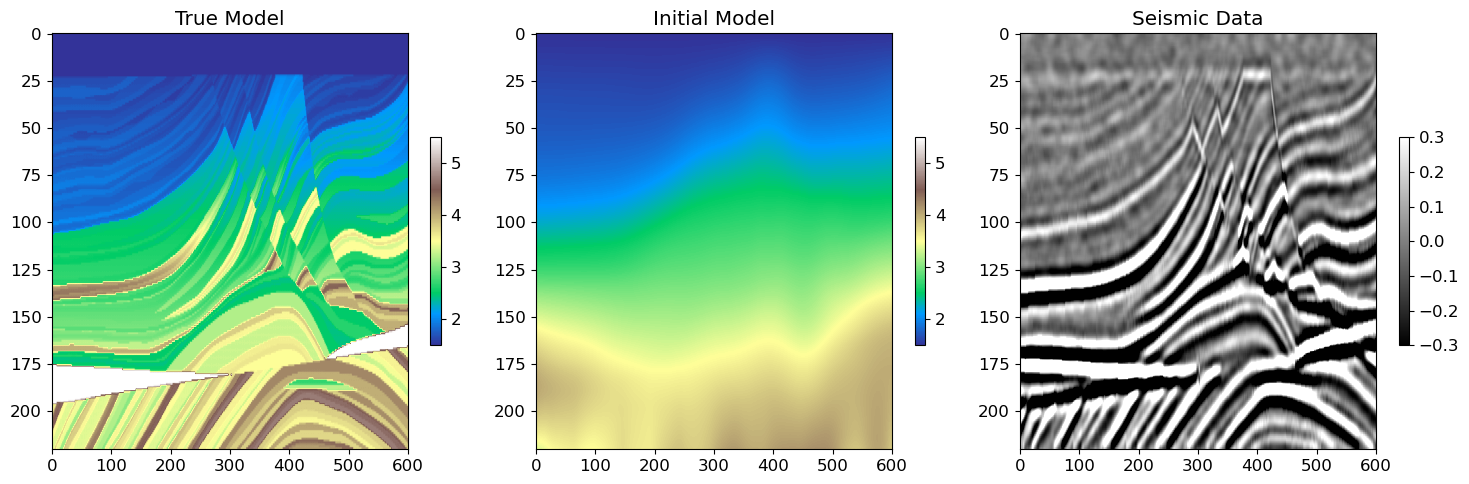

In [15]:
# Synthetic impedance model
inputfile = '../data/poststack_model.npz'
cropped_marmousi = False

if cropped_marmousi==True:
    model_avo = np.load(inputfile)
    m = np.log(model_avo["model"][:, ::3])
    x, z = model_avo["x"][::3] / 1000.0, model_avo["z"] / 1000.0
    nx, nz = len(x), len(z)
    
    
if cropped_marmousi==False:
    nx = 601
    nz = 221
    velocity_file= '../data/Marm.bin' # true model 

    #  Load the velocity model 
    m =(np.fromfile(velocity_file, np.float32)
                  .reshape(nz, nx))

# limits
m_max = m.max()
m_min = m.min()

# smooth model
nsmoothz, nsmoothx = 60, 50
mback = filtfilt(np.ones(nsmoothz) / float(nsmoothz), 1, m, axis=0)
mback = filtfilt(np.ones(nsmoothx) / float(nsmoothx), 1, mback, axis=1)
mback = mback.copy()

Iop = pylops.Identity(m.size)

# Seismic parameters
nt0 = 301
dt0 = 0.004
t0 = np.arange(nt0) * dt0

ntwav = 61
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 15)


# Post-Stack dense operator
PPop_dense = pylops.avo.poststack.PoststackLinearModelling(
    wav / 2, nt0=nz, spatdims=nx, explicit=True
)

# Post-Stack operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nz, spatdims=nx)
Op = PPop


# synthetic noise-free seismic
d = (PPop_dense * m.ravel()).reshape(nz, nx)

# synthetic seismic with colored noise
sigman = 3e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nz, nx)).T, method='gust').T,
             method='gust')
dn = d + n

# synthetic seismic with Gaussian noise
n2 = np.random.normal(0, 1e-1, d.shape)
dn2 = d + n2

# Scale for the models ploting
vmin, vmax = np.percentile(m, [1,99])


fig, ax = plt.subplots(1,3, figsize=(15,5))
ax0=ax[0].imshow(m, cmap="terrain" ,vmin=vmin, vmax=vmax)
ax[0].set_title('True Model')
ax[0].axis('tight')
plt.colorbar(ax0, ax=ax[0], shrink=0.5)
ax1=ax[1].imshow(mback, cmap="terrain", vmin=vmin, vmax=vmax)
ax[1].set_title('Initial Model')
ax[1].axis('tight')
plt.colorbar(ax1, ax=ax[1], shrink=0.5)
ax2=ax[2].imshow(dn, cmap="gray", vmin=-0.3, vmax=0.3)
ax[2].set_title('Seismic Data')
ax[2].axis('tight')
plt.colorbar(ax2, ax=ax[2], shrink=0.5)
fig.tight_layout()

## L2-Regularized Inversion

In [3]:
# L2 regularized inversion

minv1 = RegularizedInversion(PPop_dense, None, dn.ravel(),
                            x0=mback.ravel(), epsRs=[0.1], returninfo=False,
                            **dict(iter_lim=2000))

minv1 = minv1.reshape(nz, nx)


Dop = Laplacian(dims=(nz, nx), dtype=PPop_dense.dtype)
minv2 = RegularizedInversion(PPop_dense, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[1], returninfo=False,
                            **dict(iter_lim=2000))
minv2 = minv2.reshape(nz, nx)


minv3 = RegularizedInversion(PPop_dense, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[1], returninfo=False,
                            **dict(iter_lim=2000), damp=0.1)
minv3 = minv3.reshape(nz, nx)

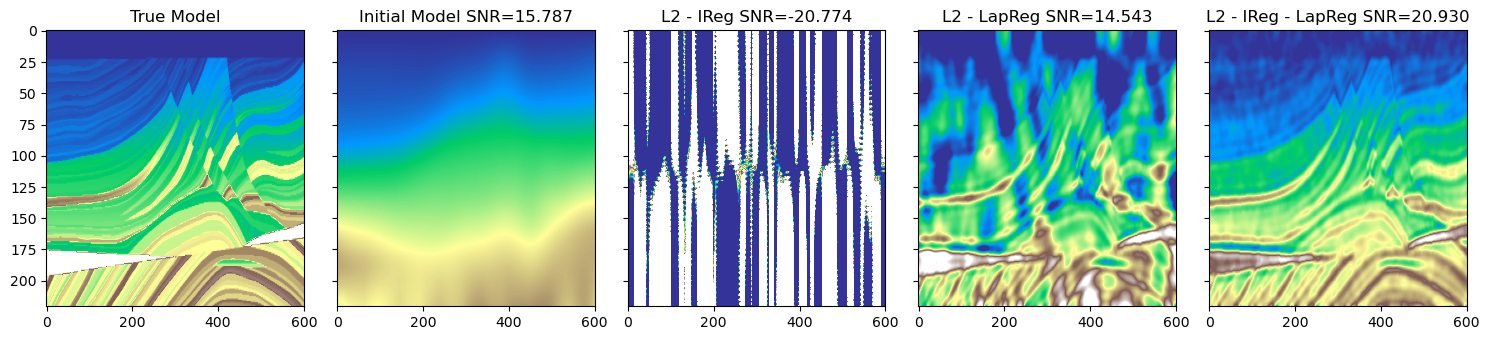

In [4]:
fig, ax = plt.subplots(1,5, figsize=(15,3.5), sharey=True)
ax0=ax[0].imshow(m, cmap="terrain" ,vmin=vmin, vmax=vmax)
ax[0].set_title('True Model')
ax[0].axis('tight')

ax1=ax[1].imshow(mback, cmap="terrain", vmin=vmin, vmax=vmax)
ax[1].set_title('Initial Model SNR=%.3f' % snr(m, mback))
ax[1].axis('tight')
                
ax2=ax[2].imshow(minv1, cmap="terrain", vmin=vmin, vmax=vmax)
ax[2].set_title('L2 - IReg SNR=%.3f' % snr(m, minv1))
ax[2].axis('tight')
fig.tight_layout()
                
ax2=ax[3].imshow(minv2, cmap="terrain", vmin=vmin, vmax=vmax)
ax[3].set_title('L2 - LapReg SNR=%.3f' % snr(m, minv2))
ax[3].axis('tight')
fig.tight_layout()
                
ax2=ax[4].imshow(minv3, cmap="terrain", vmin=vmin, vmax=vmax)
ax[4].set_title('L2 - IReg - LapReg SNR=%.3f' % snr(m, minv3))
ax[4].axis('tight')
fig.tight_layout()

## TV-Regularized Inversion (PD)

In [5]:
#----------------------------- TV

# L2 proximal Operator
l2 = pyproximal.proximal.L2(Op=Op, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)

sigma=0.05 #( = 1/eps )
l1 = L21(ndim=2, sigma=sigma)
Dop = pylops.Gradient(dims=(nz, nx), edge=True, dtype=Op.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L
xerrhisttv = []
xhisttv = []
yerrhisttv = []
yhisttv = []

mpd = PrimalDual(l2, l1, Dop, tau=tau, mu=mu, theta=1., x0=mback.ravel(), niter=100, gfirst=True,
                 callback=lambda xx: callback0(xx, m.ravel(), xhisttv,xerrhisttv))

mpd = mpd.reshape(nz, nx)    

## Plug and Play

### Loading Deep Denoisers

In [6]:
# Pre-trained DnCNN 
model_01 = DnCNN_17() 
model_01.load_state_dict(torch.load('../models/model_dict.pth'))
model_01.eval().to(cuda0);

# Pre-trained DRUNet
model_02 = UNetRes(in_nc=2)
# Download drunet_gray.pth from https://drive.google.com/drive/folders/1uEYx0GR4D7q5UMsc1qFVW1KeyVYI_hE-?usp=sharing
# and place it on /models directory
model_02.load_state_dict(torch.load('../models/drunet_gray.pth'))
model_02.eval().to(cuda0);

### PnP using BM3D as denoiser

In [7]:
#--------------------------- BM3D 
sigma = 1e-1
denoiser_bm = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma ,
                                     stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
tau = 10. #/L
mu = .1  #* tau / L
xerrhistbm = []
xhistbm = []
yerrhistbm = []
yhistbm = []
xpnp_bm = PlugAndPlay_PrimalDual(l2, denoiser_bm, Iop, m.shape,
                                               tau=tau, x0=mback.ravel(),
                                               niter=100, mu=mu,
                                               callback=lambda xx, yy: callback(xx, yy, m.ravel(), xhistbm, 
                                                                                yhistbm, xerrhistbm, yerrhistbm))

xpnp_bm = xpnp_bm.reshape(m.shape)

### PnP using DnCNN and DRUNet as denoisers

In [8]:
#------------------------- DnCNN

tau = 2. #/L
mu = .005 
denoiser_dn = lambda x, mu_: Denoiser_scale_iter(model_01, torch.from_numpy(x).float(), mu_)
xerrhist01 = []
xhist01 = []
yerrhist01 = []
yhist01 = []
xpnp_dn01 = PlugAndPlay_PrimalDual(l2, denoiser_dn, Iop, m.shape,
                                               tau=tau, x0=mback.ravel(), mu=mu,
                                               niter=100, 
                                               callback=lambda xx, yy: callback(xx, yy, m.ravel(), xhist01, 
                                                                                yhist01, xerrhist01, yerrhist01))
xpnp_dn01 = xpnp_dn01.reshape(m.shape)


#--------------------------- DRUNET Pre-Trained 

l2 = pyproximal.proximal.L2(Op=Op, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)

tau = 6. #/L
mu = .1 
sigma = .001
denoiser_dn = lambda x, mu_: scaling_DRUNET(model_02, torch.from_numpy(x).float(), mu_, sigma, verb=False)

xerrhist02 = []
xhist02 = []
yerrhist02 = []
yhist02 = []
xpnp_dn02 = PlugAndPlay_PrimalDual(l2, denoiser_dn, Iop, m.shape,
                                               tau=tau, x0=mback.ravel(), mu=mu,
                                               niter=100, 
                                               callback=lambda xx, yy: callback(xx, yy, m.ravel(), xhist02, 
                                                                                yhist02, xerrhist02, yerrhist02), show=True)
xpnp_dn02 = xpnp_dn02.reshape(m.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pnpseismic.PnP_seismic._Denoise'>
Linear operator (A): <class 'pylops.basicoperators.Identity.Identity'>
Additional vector (z): None
tau = 6.000000e+00	mu = 1.000000e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.48742e+00   2.840e+02   0.000e+00   0.000e+00       2.840e+02
     2   1.48569e+00   9.257e+01   0.000e+00   0.000e+00       9.257e+01
     3   1.48595e+00   6.381e+01   0.000e+00   0.000e+00       6.381e+01
     4   1.48978e+00   5.563e+01   0.000e+00   0.000e+00       5.563e+01
     5   1.48801e+00   5.210e+01   0.000e+00   0.000e+00       5.210e+01
     6   1.48209e+00   5.040e+01   0.000e+00   0.000e+00       5.040e+01
     7   1.47431e+00   4.928e+01   0.000e+00   0.000e+00       4.928e+01
     8   1.46671e+00   4.871

## Results

Comparison of L2 and TV regularized inversions, and PnP with denoisers

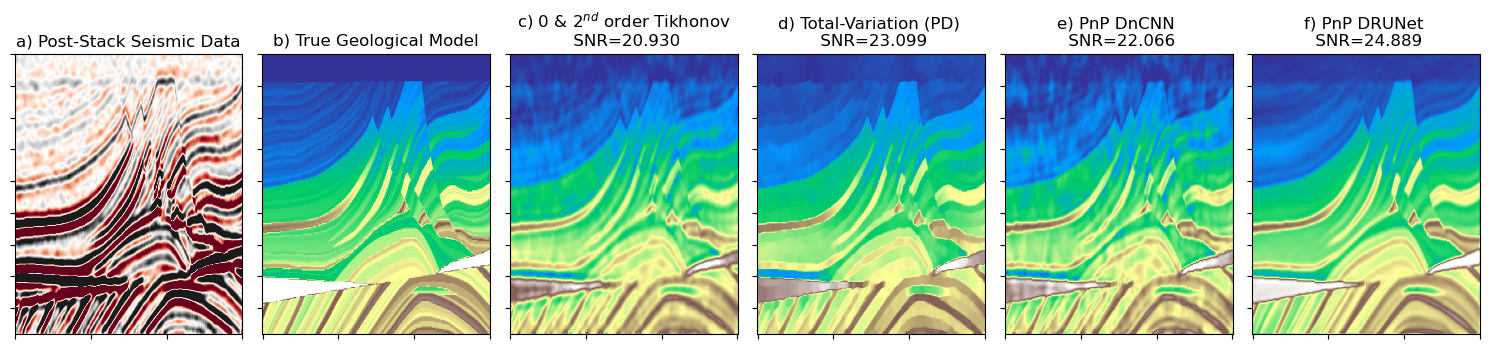

In [9]:
cmap = 'terrain'
plt.rcParams['font.size'] = '10'
vmin, vmax = np.percentile(m, [1,99])
fig, ax = plt.subplots(1,6, figsize=(15,3.6))
ax[0].imshow(dn, cmap="RdGy", vmin=-0.3, vmax=0.3)
ax[0].set_title('a) Post-Stack Seismic Data')
ax[0].axis('tight')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([]) 
ax[1].imshow(m, cmap=cmap ,vmin=vmin, vmax=vmax)
ax[1].set_title('b) True Geological Model')
ax[1].axis('tight')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([]) 
ax[2].imshow(minv3, cmap=cmap, vmin=vmin, vmax=vmax)
ax[2].set_title('c) 0 & $2^{nd}$ order Tikhonov \n SNR=%.3f' % snr(m, minv3))
ax[2].axis('tight')       
ax[2].set_xticklabels([])
ax[2].set_yticklabels([]) 
ax[3].imshow(mpd, cmap=cmap, vmin=vmin, vmax=vmax)
ax[3].set_title('d) Total-Variation (PD) \n SNR=%.3f' % snr(m, mpd))
ax[3].axis('tight')
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])        
ax[4].imshow(xpnp_dn01, cmap=cmap, vmin=vmin, vmax=vmax)
ax[4].set_title('e) PnP DnCNN \n SNR=%.3f' % snr(m, xpnp_dn01,))
ax[4].axis('tight')
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])     
ax[5].imshow(xpnp_dn02, cmap=cmap, vmin=vmin, vmax=vmax)
ax[5].set_title('f) PnP DRUNet \n SNR=%.3f' % snr(m, xpnp_dn02))
ax[5].axis('tight')
ax[5].set_xticklabels([])
ax[5].set_yticklabels([]) 
fig.tight_layout()

# plt.savefig('results_1.eps', format='eps')
# plt.savefig('results_2.png', format='png', dpi=100)

Error convergence curves

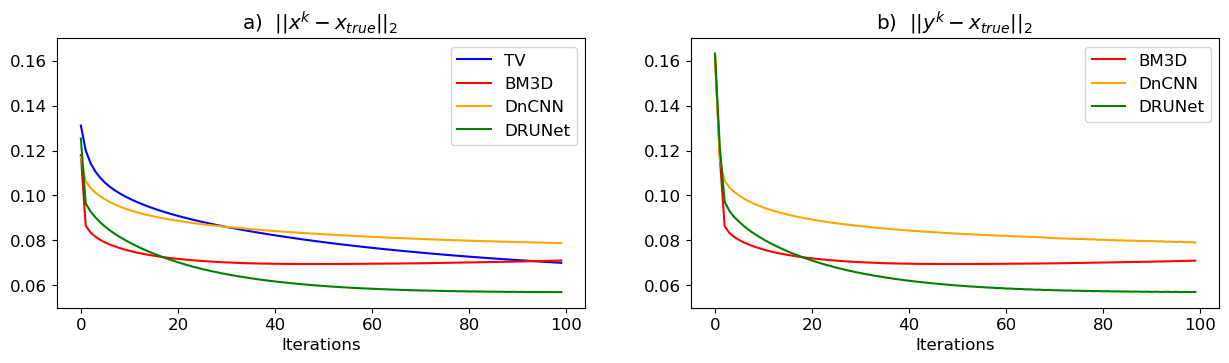

In [14]:
plt.rcParams['font.size'] = '12'
fig, axs = plt.subplots(1, 2, figsize=(15,3.5))
axs[0].plot(xerrhisttv, 'b', label='TV')
axs[0].plot(xerrhistbm, 'r', label='BM3D')
axs[0].plot(xerrhist01, 'orange', label='DnCNN')
axs[0].plot(xerrhist02, 'g', label='DRUNet')
axs[0].set_title(r'a)  $||x^k - x_{true}||_2$ ')
axs[0].set_xlabel('Iterations')
axs[0].set_ylim(0.05, 0.17)
# axs[1].plot(yerrhisttv, label='TV')
axs[1].plot(yerrhistbm, 'r', label='BM3D')
axs[1].plot(yerrhist01,'orange',  label='DnCNN')
axs[1].plot(yerrhist02,'g', label='DRUNet')
axs[1].set_title(r'b)  $||y^k - x_{true}||_2$ ')
axs[1].set_xlabel('Iterations')
axs[1].set_ylim(0.05, 0.17)
axs[0].legend()
axs[1].legend()
# plt.savefig('error_plot.png', format='png', dpi=100)

Inversion and denoising intermediate steps in PnP-DRUNet

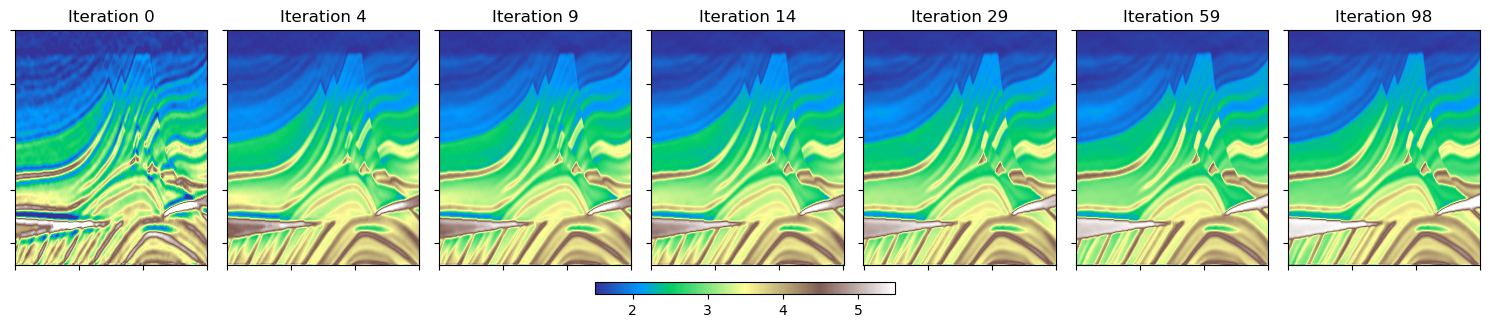

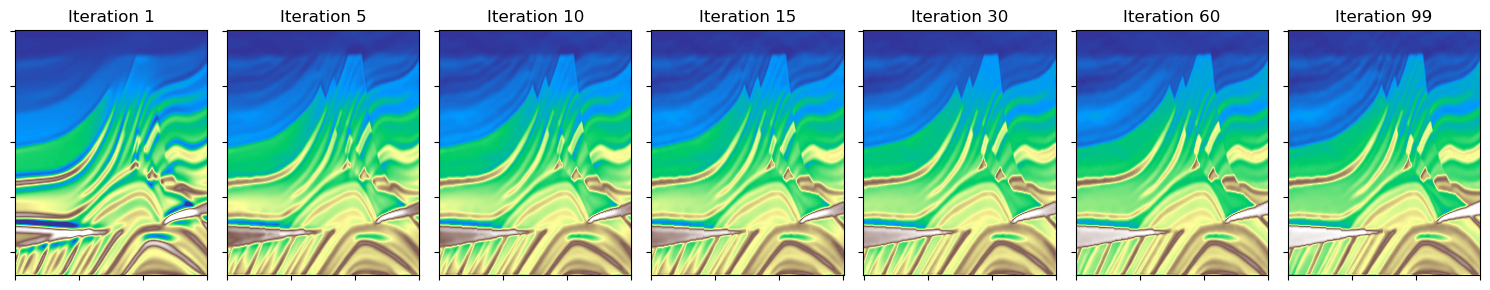

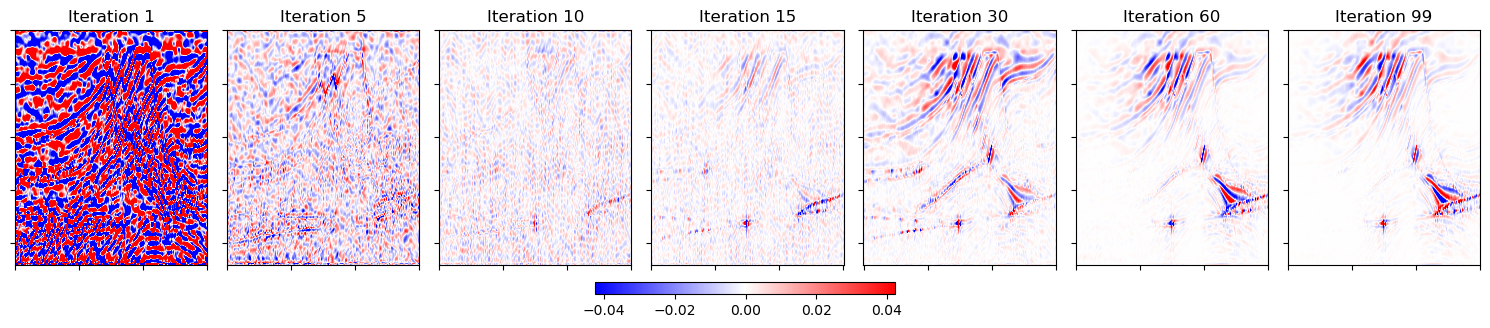

In [12]:
plt.rcParams['font.size'] = '10'

iiter = np.array([0, 4, 9, 14, 29, 59, 98])
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(15,3))
axs = axs.ravel()
vmin, vmax = np.percentile(m, [1,99])
for i, k in zip(range(7), iiter):
    axi=axs[i].imshow(np.real(xhist02[k]).reshape(m.shape), vmin=vmin, vmax=vmax, cmap="terrain")
    axs[i].set_title('Iteration %d' % k)
    axs[i].axis('tight')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.4, 0.001, 0.2, 0.04])
fig.colorbar(axi, cax=cbar_ax, orientation='horizontal')

iiter = np.array([1, 5, 10, 15, 30, 60, 99])
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(15,3))
axs = axs.ravel()
vmin, vmax = np.percentile(m, [1,99])
for i, k in zip(range(7), iiter):
    axs[i].imshow(np.real(yhist02[k]).reshape(m.shape), vmin=vmin, vmax=vmax, cmap="terrain")
    axs[i].set_title('Iteration %d' % k)
    axs[i].axis('tight')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
fig.tight_layout()

iiter = np.array([1, 5, 10, 15, 30, 60, 99])
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(15,3))
axs = axs.ravel()
vmin, vmax = np.percentile((yhist02[5]-xhist02[4]), [1,99])
for i, k in zip(range(7), iiter):
    axi=axs[i].imshow(np.real(yhist02[k]-xhist02[k-1]).reshape(m.shape), vmin=vmin, vmax=vmax, cmap='bwr')
    axs[i].set_title('Iteration %d' % k)
    axs[i].axis('tight')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
fig.tight_layout()

fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.4, 0.001, 0.2, 0.04])
fig.colorbar(axi, cax=cbar_ax, orientation='horizontal')